In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.init as init
import os, glob
from datetime import datetime
import pandas as pd
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import GridSearchCV
from skorch import NeuralNetClassifier


C:\Users\Isaac\anaconda3\envs\CS273\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Question 3

CNN tuning: Focus on simulation setting 7 to optimize your CNN for improved 
classification performance on the test set. Generate an independent validation set of 1000 
subjects to assist in tuning. Define a search space for the number of convolution layers, 
the width of the final fully connected layer, and the optimizer's learning rate. Conduct a 
grid search over the defined search space to identify the best hyperparameter 
combination. Report the search space, selected hyperparameters, and the classification 
accuracy for each combination tested.

* Use model a base model.
    * Remember only using data setting 7. [X]
    * have only one train (n_i), one validation (1000), and one test set (1000) [X]
    * number of convolution layers: 1, 2, 3, 4, 5
    * Readjust model with different final fully connected layers: 8, 16, 32, 64, 128
    * lr = 0.001, .01, .1

In [2]:
def simulateData(n, mu_c, mu_n):

    y = np.random.choice([0, 1], size = n, p = [0.5, 0.5])
    m_i = np.random.poisson(lam = mu_c, size = n) * y + np.random.poisson(lam = mu_n, size = n) * (1 - y)

    simulated_data = np.zeros([n, 32, 32])
    for i in range(n):
        random_indices = np.random.choice(32 * 32, m_i[i], replace = False)
        row_indices, col_indices = np.unravel_index(random_indices, (32, 32))
        Bi = np.zeros([32, 32])
        Bi[row_indices, col_indices] = 1
        epsilon_i = np.random.normal(loc = 0, scale = np.sqrt(0.04), size = (32, 32))
        simulated_data[i] = Bi + epsilon_i

    return y, simulated_data

In [3]:
y_train, X_train = simulateData(n = 200, mu_c = 5, mu_n = 30)
y_val, X_val = simulateData(n = 1000, mu_c = 5, mu_n = 30)
y_test, X_test = simulateData(n = 1000, mu_c = 5, mu_n = 30)


In [4]:
class dataSetPytorch(Dataset):
    def __init__(self, x, y):
        self.x = torch.from_numpy(x.reshape([-1, 1, 32, 32])).float()
        self.y = torch.from_numpy(y)
    def __len__(self):
        return len(self.x)
    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]
    
def reset_weights(model):
    for m in model.modules():
        if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
            init.xavier_uniform_(m.weight)
    return

def saveModel(model, path):
    torch.save(model.state_dict(), path)

In [5]:
exampleImg = X_train[0, :, :].reshape([1, 1, 32, 32])
exampleImg = torch.from_numpy(exampleImg).float()
exampleImg.shape

torch.Size([1, 1, 32, 32])

#### Model Base

In [6]:
# Define the base model
class BaseCNN(torch.nn.Module):
    def __init__(self, num_conv_layers, final_fc_width):
        super(BaseCNN, self).__init__()
        
        self.num_conv_layers = num_conv_layers
        
        # Define convolutional layers dynamically based on num_conv_layers
        self.conv_layers = nn.ModuleList()
        
        in_channels = 1  #  input channels = 1
        out_channels = 2  # Initial output channels
        for i in range(num_conv_layers):
            self.conv_layers.append(nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1))
            self.conv_layers.append(nn.ReLU())
            self.conv_layers.append(nn.MaxPool2d(kernel_size=2))
            # Update in_channels and out_channels for the next layer
            in_channels = out_channels
            out_channels *= 2  # Double the channels for each subsequent layer
        
        # Calculate the input size for the fully connected layer
        conv_output_size = self._get_conv_output_size()
        
        self.flatten = torch.nn.Flatten()
        self.fc = nn.Linear(conv_output_size, final_fc_width)
        self.relu = nn.ReLU()
        self.output_layer = nn.Linear(final_fc_width, 1)
        self.sigmoid = torch.nn.Sigmoid()
    
    def forward(self, x):
        # Forward pass through convolutional layers
        for conv_layer in self.conv_layers:
            x = conv_layer(x)
        
        # Flatten the output from convolutional layers
        x = self.flatten(x)
        
        # Forward pass through fully connected layers
        x = self.relu(self.fc(x))
        x = self.output_layer(x)
        x = self.sigmoid(x)
        return x
    
    def _get_conv_output_size(self):
        # Method to calculate the output size of the convolutional layers
        x = torch.rand(1, 1, 32, 32)  # Assuming input size is 28x28
        for conv_layer in self.conv_layers:
            x = conv_layer(x)
        return x.view(1, -1).size(1)
    
    def reset_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
                init.xavier_uniform_(m.weight)
        return
    
    def fit(self, X_train, X_val, y_train, y_val, learningRate, num_epochs = 200):        

        datasetSetting_train = dataSetPytorch(X_train, y_train)
        train_dl = DataLoader(datasetSetting_train, batch_size=25, shuffle = True)

        datasetSetting_val = dataSetPytorch(X_val, y_val)
        valid_dl = DataLoader(datasetSetting_val, batch_size=25, shuffle = True)

        # reinitialize weights!
        self.reset_weights()

        loss_fn = torch.nn.BCELoss()
        optimizer = torch.optim.Adam(model.parameters(), lr = learningRate)
        loss_hist_train = [0] * num_epochs
        accuracy_hist_train = [0] * num_epochs
        loss_hist_valid = [0] * num_epochs
        accuracy_hist_valid = [0] * num_epochs 

        best_loss = torch.inf

        for epoch in range(num_epochs):
            self.train()

            for x_batch, y_batch in train_dl:
                pred = self(x_batch)[:, 0]
                loss = loss_fn(pred, y_batch.float())
                loss.backward()
                optimizer.step()
                optimizer.zero_grad()
                loss_hist_train[epoch] += loss.item() * y_batch.size(0)

                is_correct = ((pred >= 0.5).float() == y_batch).float()
                accuracy_hist_train[epoch] += is_correct.sum()
            loss_hist_train[epoch] /= len(train_dl.dataset)
            accuracy_hist_train[epoch] /= len(train_dl.dataset)

            self.eval()
            with torch.no_grad():
                for x_batch, y_batch in valid_dl:
                    pred = self(x_batch)[:, 0]
                    loss = loss_fn(pred, y_batch.float())
                    loss_hist_valid[epoch] += loss.item() * y_batch.size(0)

                    is_correct = ((pred >= 0.5).float() == y_batch).float()
                    accuracy_hist_valid[epoch] += is_correct.sum()
            loss_hist_valid[epoch] /= len(valid_dl.dataset)
            accuracy_hist_valid[epoch] /= len(valid_dl.dataset)

            if (best_loss > loss_hist_valid[epoch]):
                saveModel(model, "bestModel.pth")
                best_loss = loss_hist_valid[epoch]
                
        modelWeightParams = torch.load("bestModel.pth")
        self.load_state_dict(modelWeightParams)
        
    def predict_score(self, X_test, y_test):
        datasetSetting_test = dataSetPytorch(X_test, y_test)
        test_dl = DataLoader(datasetSetting_test, batch_size=25, shuffle = True)

        # model is done training, now evaluate the test accuracy score here.
        accuracy_test = 0
        self.eval()
        with torch.no_grad():
            for x_batch, y_batch in test_dl:
                pred = self(x_batch)[:, 0]
                is_correct = ((pred >= 0.5).float() == y_batch).float()
                accuracy_test += is_correct.sum()   
        accuracy_test /= len(test_dl.dataset)

        return accuracy_test.numpy()       
        


array(0.973, dtype=float32)

### Grid Search.
Im making my own custom one, oculdnt figure it out with sklearn. Im going to continue what i did and select best model based on best validation performance, since i care most about accuracy. Then im going to run the model on the test data set. Im going to attempt all possible combinations here, and I will select the best model with whatever parameters performed best.

Trial run

In [ ]:
    
param_dict = {
    'final_fc_width': 8,
    'num_conv_layers': 1,
    'learningRate': 0.001,
}

# Create an instance of MyModel
model = BaseCNN(num_conv_layers = param_dict["num_conv_layers"], final_fc_width = param_dict["final_fc_width"])
model.fit(X_train, X_val, y_train, y_val, 
          param_dict['learningRate'], num_epochs = 200)
model.predict_score(X_test, y_test)

Full send it ma boi

In [10]:
import itertools

# Define the hyperparameter grid
param_grid = {
    'final_fc_width': [8, 16, 32, 64],
    'num_conv_layers': [1, 2, 3, 4, 5],
    'learningRate': [0.001, 0.005, 0.01, 0.1],
}

# Generate all combinations of hyperparameters
param_combinations = list(itertools.product(*param_grid.values()))

final_fc_width = []
num_conv_layers = []
learningRate = []
accuracy = []

# Print the combinations
for params in param_combinations:
    print("Running final_fc_width", params[0], "num_conv_layers", params[1], "learningRate", params[2])
    # Create an instance of MyModel
    model = BaseCNN(num_conv_layers = params[1], final_fc_width = params[0])
    model.fit(X_train, X_val, y_train, y_val, learningRate = params[2], num_epochs = 200)
    accuracy.append(model.predict_score(X_test, y_test))
    final_fc_width.append(params[0])
    num_conv_layers.append(params[1])
    learningRate.append(params[2])


Running final_fc_width 8 num_conv_layers 1 learningRate 0.001
Running final_fc_width 8 num_conv_layers 1 learningRate 0.005
Running final_fc_width 8 num_conv_layers 1 learningRate 0.01
Running final_fc_width 8 num_conv_layers 1 learningRate 0.1
Running final_fc_width 8 num_conv_layers 2 learningRate 0.001
Running final_fc_width 8 num_conv_layers 2 learningRate 0.005
Running final_fc_width 8 num_conv_layers 2 learningRate 0.01
Running final_fc_width 8 num_conv_layers 2 learningRate 0.1
Running final_fc_width 8 num_conv_layers 3 learningRate 0.001
Running final_fc_width 8 num_conv_layers 3 learningRate 0.005
Running final_fc_width 8 num_conv_layers 3 learningRate 0.01
Running final_fc_width 8 num_conv_layers 3 learningRate 0.1
Running final_fc_width 8 num_conv_layers 4 learningRate 0.001
Running final_fc_width 8 num_conv_layers 4 learningRate 0.005
Running final_fc_width 8 num_conv_layers 4 learningRate 0.01
Running final_fc_width 8 num_conv_layers 4 learningRate 0.1
Running final_fc_wid

In [28]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

param_combinations = {
    'final_fc_width': final_fc_width,
    'num_conv_layers': num_conv_layers,
    'learningRate':learningRate,
    'accuracy': accuracy
}

DataSettignsdf = pd.DataFrame(param_combinations)
display(DataSettignsdf)

,final_fc_width,num_conv_layers,learningRate,accuracy
0,8,1,0.001,0.947
1,8,1,0.005,0.988
2,8,1,0.010,0.979
3,8,1,0.100,0.97
4,8,2,0.001,0.997
5,8,2,0.005,0.997
6,8,2,0.010,0.993
7,8,2,0.100,0.499
8,8,3,0.001,0.989
9,8,3,0.005,0.995


In [60]:
DataSettignsdf.to_csv('data7Training.csv', index=False)

In [29]:
indexMax = np.argmax(DataSettignsdf['accuracy'].values)
DataSettignsdf.iloc[[indexMax]]

,final_fc_width,num_conv_layers,learningRate,accuracy
25,16,2,0.005,0.998


Lets explore the data now

In [59]:
param_grid

{'final_fc_width': [8, 16, 32, 64],
 'num_conv_layers': [1, 2, 3, 4, 5],
 'learningRate': [0.001, 0.005, 0.01, 0.1]}

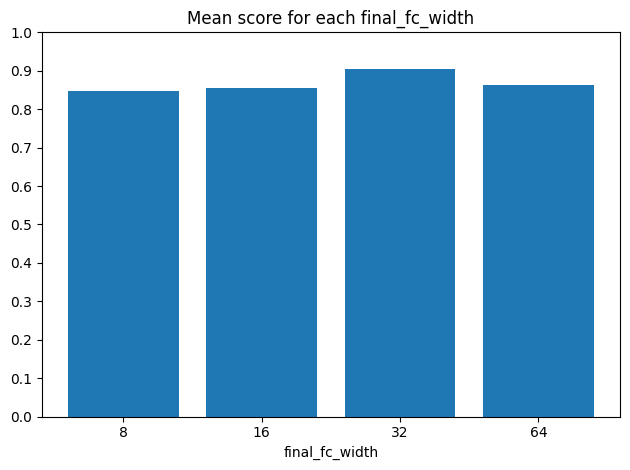

In [56]:
score_avg = []
for item in param_grid["final_fc_width"]:
    score_avg.append(DataSettignsdf[DataSettignsdf["final_fc_width"] == item]["accuracy"].mean())

plt.figure()
plt.bar(["8", "16", "32", "64"], score_avg)
ax = plt.gca()
ax.set_yticks([i/10 for i in range(11)])
plt.title("Mean score for each final_fc_width")
plt.xlabel("final_fc_width")
plt.tight_layout()

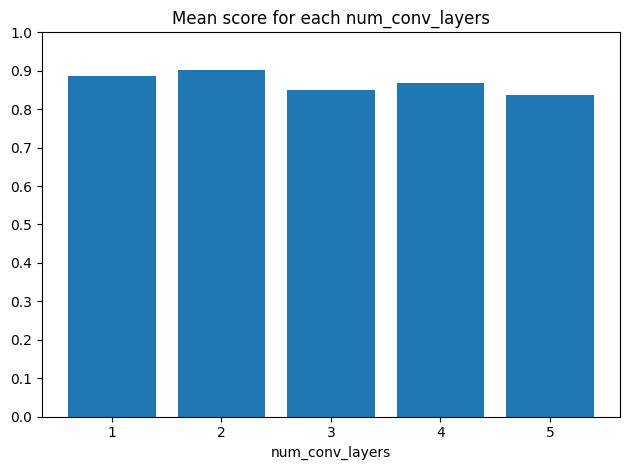

In [55]:
score_avg = []
for item in param_grid["num_conv_layers"]:
    score_avg.append(DataSettignsdf[DataSettignsdf["num_conv_layers"] == item]["accuracy"].mean())

plt.figure()
plt.bar(["1", "2", "3", "4", "5"], score_avg)
ax = plt.gca()
ax.set_yticks([i/10 for i in range(11)])
plt.title("Mean score for each num_conv_layers")
plt.xlabel("num_conv_layers")
plt.tight_layout()

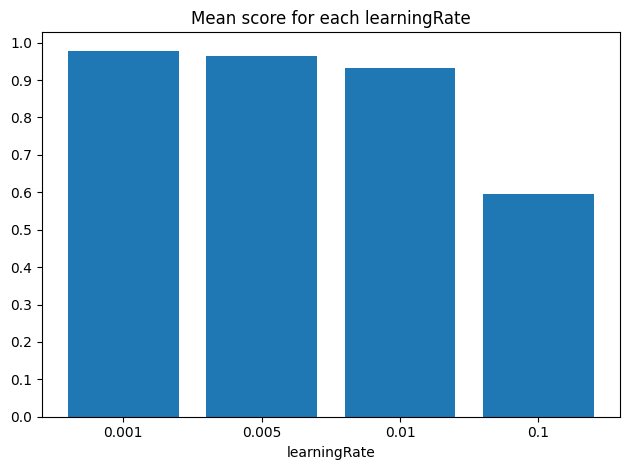

In [57]:
score_avg = []
for item in param_grid["learningRate"]:
    score_avg.append(DataSettignsdf[DataSettignsdf["learningRate"] == item]["accuracy"].mean())

plt.figure()
plt.bar(["0.001", "0.005", "0.01", "0.1"], score_avg)
ax = plt.gca()
ax.set_yticks([i/10 for i in range(11)])
plt.title("Mean score for each learningRate")
plt.xlabel("learningRate")
plt.tight_layout()